## More Ways to Win: Cards
##### 1. Calculate Scenario of if we paid out last year
##### 2. Table - Brand/Pre-Match Vs InPlay/Bet Mix
##### 3A. Get Average number of Cards per game 24/25 in PL
##### 3B. Get Margin on cards market for 24/25 in PL season & %, Game
##### 3C. How does this effect margin
##### 4. Worst case scenario
##### 5. West Ham Vs Wolves game

In [1]:
import os
import redshift_utils as rs
import pandas as pd
import time
import sagemaker
import boto3
from skrub import TableReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skrub import TableReport

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
bucket = "edcs3.prod.biads"
boto_session = boto3.session.Session(region_name="eu-west-1")
sess = sagemaker.session.Session(boto_session, default_bucket=bucket)
region = sess.boto_session.region_name
account = sess.boto_session.client('sts').get_caller_identity()['Account']
role = sagemaker.get_execution_role()
ssm_client = boto3.client('ssm')
kms_key = ssm_client.get_parameter(Name='/prod/sagemaker/BIADS/sloth/KMS_KEY_ID', WithDecryption=True)["Parameter"]["Value"] 

def load_data(params, sql):
    sloth_credentials = rs.get_sloth_credentials()
    con = rs.connect_to_redshift(sloth_credentials)
    data = rs.execute_sql(
        RSconn=con,
        sql=sql,
        input_type="file",
        params=params
    )
    return data

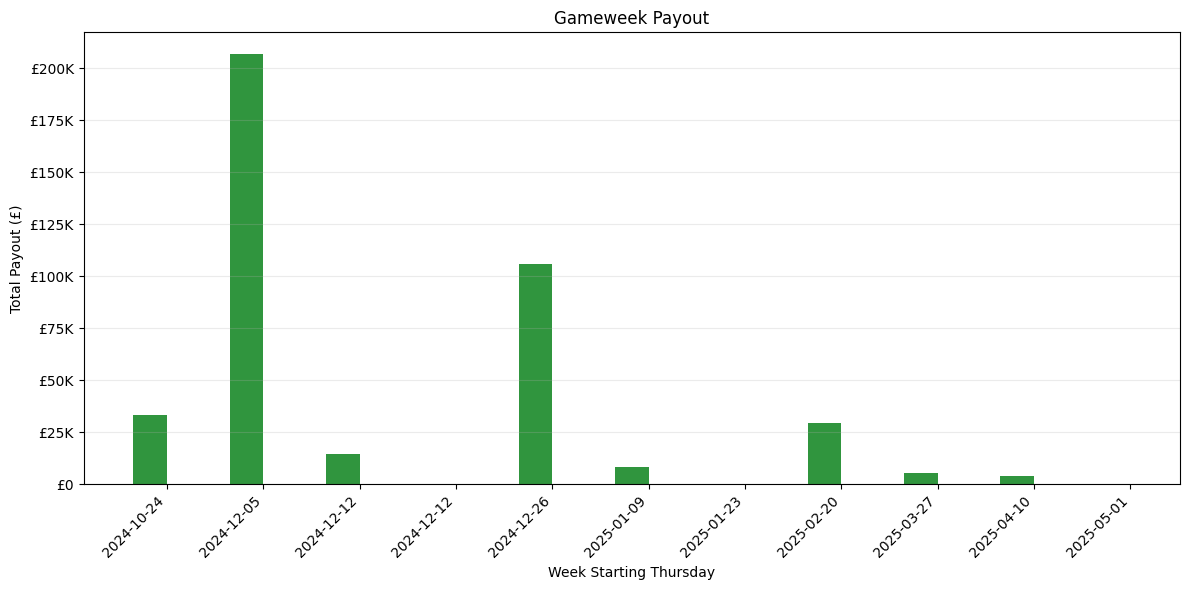

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import base64
from datetime import timedelta

df['event_scheduled_start_datetime'] = pd.to_datetime(df['event_scheduled_start_datetime'])

# --- Define Week Start (Thursday) ---
# Thursday is dayofweek 3 (Monday=0, Sunday=6)
def get_thursday_week_start(dt):
    # Calculate days to subtract to get to the preceding Thursday
    # If it's Mon, Tue, Wed, it belongs to the previous Thursday's week.
    # If it's Thu, Fri, Sat, Sun, it belongs to the current Thursday's week.
    days_since_thursday = (dt.dayofweek - 3) % 7
    return dt - timedelta(days=days_since_thursday)

df['week_start_thursday'] = df['event_scheduled_start_datetime'].apply(get_thursday_week_start)

# --- Aggregate Data ---
# Group by the custom week start and sum 'pay', count 'mult_id'
grouped_data = df.groupby('week_start_thursday').agg(
    total_payout=('potential_payout', 'sum')
).reset_index()

# Sort by week start date to ensure correct order in plot
grouped_data = grouped_data.sort_values(by='week_start_thursday')

# --- FORMATTING ---
# Currency formatter for the y-axis
def currency_formatter_bmt(x, pos):
    if x >= 1_000_000_000:
        return f'£{x*1e-9:1.1f}B'
    if x >= 1_000_000:
        return f'£{x*1e-6:1.1f}M'
    if x >= 1_000:
        return f'£{x*1e-3:1.0f}K'
    return f'£{x:1.0f}'

# --- Visualization ---
# Colors
pay_color = '#30953e' # Light green

fig, ax1 = plt.subplots(figsize=(12, 6)) # Create figure and first axis

# Bar width and positions
bar_width = 0.35
indices = range(len(grouped_data))

# Plot 'total_pay' on primary y-axis
rects1 = ax1.bar([i - bar_width/2 for i in indices], grouped_data['total_payout'], bar_width, label='Total Payout', color=pay_color)
ax1.set_xlabel('Week Starting Thursday')
ax1.set_ylabel('Total Payout (£)')
ax1.tick_params(axis='y')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter_bmt))

# Set x-axis ticks and labels
ax1.set_xticks(indices)
ax1.set_xticklabels(grouped_data['week_start_thursday'].dt.strftime('%Y-%m-%d'), rotation=45, ha='right')

# Title and Layout
plt.title('Gameweek Payout')
fig.tight_layout() # Adjust layout to prevent labels overlapping

# Add grid lines for better readability
ax1.grid(axis='y', linestyle='-', alpha=0.25)


# Combine legends
lines, labels = ax1.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot (for local execution)
plt.show()


##### 1. Calculate Scenario of if we paid out last year


In [58]:
# Create prep table
params = {'@iam': 'arn:aws:iam::765819017647:role/rs-edcs3.prod.marketing',
          '@kms': kms_key, 
         }
data = load_data(params=params, sql='../data/cards_25.sql')
pd.set_option('display.max_columns', None)  # Show all columns
df = pd.DataFrame(data)
df.head(50)


,supersub_activated_leg_yn,total_bets
0,Y,14
1,N,3335


In [46]:
styled_df_basic_format = df.style.format({
    'total_stakes': "£{:,.0f}",  # Currency, no decimals
    'total_payout': "£{:,.0f}",  # Currency, no decimals
    'cost_to_margin_pcnt': "{:.2%}",  # Percentage with 2 decimals
})
print(styled_df_basic_format.to_string())

 supersub_activated_leg_yn in_play_yn bet_type total_stakes total_payout cost_to_margin_pcnt
0 N N Multiple £8,240 £249,442 213.00%
1 Y N Multiple £43 £1,929 12.00%
2 N Y Multiple £2,238 £73,072 313.00%
3 Y Y Multiple £10 £249 11.00%
4 N N Single £1,771 £6,033 20.00%
5 N Y Single £10,122 £76,701 173.00%



In [42]:
# Using pivot_table with multiple aggregations (e.g., sum and mean)
pivot_multi_agg = pd.pivot_table(df, 
                                 values=['total_stakes', 'total_payout'], 
                                 index=['bet_type'],
                                 columns=['supersub_activated_leg_yn',	'in_play_yn',	'bet_type'], 
                                 aggfunc={'total_stakes': 'sum', 'total_payout': 'sum'}, 
                                 margins=True, 
                                 margins_name='Grand Total')

print("Pivot Table with Multiple Aggregations and Grand Totals:")
print(pivot_multi_agg)
print("\n" + "="*30 + "\n")

Pivot Table with Multiple Aggregations and Grand Totals:
                            total_payout                             \
supersub_activated_leg_yn              N                              
in_play_yn                             N                          Y   
bet_type                        Multiple       Single      Multiple   
bet_type                                                              
Multiple                   249441.688153          NaN  73071.661135   
Single                               NaN  6033.122408           NaN   
Grand Total                249441.688153  6033.122408  73071.661135   

                                                                  \
supersub_activated_leg_yn                          Y               
in_play_yn                                         N           Y   
bet_type                         Single     Multiple    Multiple   
bet_type                                                           
Multiple                          

In [21]:
total_summary = df[['total_stakes', 'total_payout']].sum()
print(total_summary)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 total_summary = df[['total_stakes', 'total_payout']].sum()                                   │
│   2 print(total_summary)                                                                         │
│   3                                                                                              │
│                                                                                                  │
│ /home/sagemaker-user/.conda/envs/cenv/lib/python3.10/site-packages/pandas/core/frame.py:4108 in  │
│ __getitem__                                                                                      │
│                                                                                                  │
│    4105 │   │   else:                                                                            │
│    4106 │   │   │   if is_iterator(key):                                                         │
│    4107 │   │   │   │   key = list(key)                                                          │
│ ❱  4108 │   │   │   indexer = self.columns._get_indexer_strict(key, "columns")[1]                │
│    4109 │   │                                                                                    │
│    4110 │   │   # take() does not accept boolean indexers                                        │
│    4111 │   │   if getattr(indexer, "dtype", None) == bool:                                      │
│                                                                                                  │
│ /home/sagemaker-user/.conda/envs/cenv/lib/python3.10/site-packages/pandas/core/indexes/base.py:6 │
│ 200 in _get_indexer_strict                                                                       │
│                                                                                                  │
│   6197 │   │   else:                                                                             │
│   6198 │   │   │   keyarr, indexer, new_indexer = self._reindex_non_unique(keyarr)               │
│   6199 │   │                                                                                     │
│ ❱ 6200 │   │   self._raise_if_missing(keyarr, indexer, axis_name)                                │
│   6201 │   │                                                                                     │
│   6202 │   │   keyarr = self.take(indexer)                                                       │
│   6203 │   │   if isinstance(key, Index):                                                        │
│                                                                                                  │
│ /home/sagemaker-user/.conda/envs/cenv/lib/python3.10/site-packages/pandas/core/indexes/base.py:6 │
│ 249 in _raise_if_missing                                                                         │
│                                                                                                  │
│   6246 │   │                                                                                     │
│   6247 │   │   if nmissing:                                                                      │
│   6248 │   │   │   if nmissing == len(indexer):                                                  │
│ ❱ 6249 │   │   │   │   raise KeyError(f"None of [{key}] are in the [{axis_name}]")               │
│   6250 │   │   │                                                                                 │
│   6251 │   │   │   not_found = list(ensure_index(key)[missing_mask.nonzero()[0]].unique())       │
│   6252 │   │   │   raise KeyError(f"{not_found} not in index")                                   │
╰────────────────────────────────────────────────────────────

In [19]:

color_config = {
    'PP': {'main': '#086315', 'top': '#30953e'}, 
    'BF': {'main': '#ff7f0e', 'top': '#ffbb78'}, 
    'SBG': {'main': '#692773', 'top': '#33347c'}
}

plot_title = "Total Stakes & Payout by Brand and In-Play/ Pre-Match Status"

# --- DATA PREPARATION ---

print("Unique values in in_play_yn column:", df['in_play_yn'].unique())
print("Value counts for in_play_yn:")
print(df['in_play_yn'].value_counts())

# Group 
grouped_df = df.groupby(['brand', 'in_play_yn']).agg({
    'total_stakes': 'sum',
    'total_payout': 'sum'
}).reset_index()

# Calculate margin
grouped_df['total_margin'] = grouped_df['total_stakes'] - grouped_df['total_payout']

print("\nGrouped data:")
print(grouped_df)

# --- PLOTTING SETUP ---
brands = sorted(grouped_df['brand'].unique())
inplay_statuses = sorted(grouped_df['in_play_yn'].unique())
num_brands = len(brands)
num_inplay = len(inplay_statuses)

# Create x-axis positions for each brand-inplay combination
x_labels = []
x_indices = []
current_x = 0

for brand in brands:
    for inplay in inplay_statuses:
        x_labels.append(f"{brand}\n({'Inplay' if (inplay == 'Y') else 'Pre-match'})")
        x_indices.append(current_x)
        current_x += 1
    current_x += 0.5  # Add spacing between brands

x_indices = np.array(x_indices)

# Dynamic figure width based on the number of combinations
fig, ax = plt.subplots(figsize=(max(12, len(x_indices) * 1.2), 8))

# --- CREATE BARS ---
bar_width = 0.6

for i, (brand, inplay) in enumerate([(b, ip) for b in brands for ip in inplay_statuses]):
    # Get data for the current brand-inplay combination
    brand_inplay_data = grouped_df[
        (grouped_df['brand'] == brand) & 
        (grouped_df['in_play_yn'] == inplay)
    ]
    
    if not brand_inplay_data.empty:
        stakes = brand_inplay_data['total_stakes'].iloc[0]
        payout = brand_inplay_data['total_payout'].iloc[0]
        margin = brand_inplay_data['total_margin'].iloc[0]
        
        # Plot total_payout (the 'main' part of the bar)
        ax.bar(x_indices[i], payout, bar_width,
               color=color_config.get(brand, {}).get('main', '#808080'))
        
        # Plot total_margin on top of total_payout (to show total stakes)
        ax.bar(x_indices[i], margin, bar_width,
               bottom=payout,
               color=color_config.get(brand, {}).get('top', '#A9A9A9'))

# --- LABELS, TITLE, AND TICKS ---
ax.set_ylabel('Amount (£)', fontsize=14)
ax.set_xlabel('Brand & Match Type', fontsize=14)
ax.set_title(plot_title, fontsize=16, pad=20)
ax.set_xticks(x_indices)
ax.set_xticklabels(x_labels, rotation=45, ha="right")

# --- FORMATTING ---
# Currency formatter for the y-axis
def currency_formatter_bmt(x, pos):
    if x >= 1_000_000_000:
        return f'£{x*1e-9:1.1f}B'
    if x >= 1_000_000:
        return f'£{x*1e-6:1.1f}M'
    if x >= 1_000:
        return f'£{x*1e-3:1.0f}K'
    return f'£{x:1.0f}'

ax.yaxis.set_major_formatter(mticker.FuncFormatter(currency_formatter_bmt))

# --- LEGEND ---
# Create legend for brands and stack meaning
from matplotlib.patches import Patch
legend_elements = []

# Brand colors
for brand in brands:
    legend_elements.append(
        Patch(facecolor=color_config.get(brand, {}).get('main', '#808080'), 
              edgecolor='none', label=f'{brand}')
    )

ax.legend(handles=legend_elements, title='Brand & Components', 
          bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

# --- STYLING AND LAYOUT ---
plt.grid(True, which='major', axis='y', linestyle=':', linewidth=0.7, alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

print("\nSummary by Brand and Inplay Status:")
print("=" * 50)
for brand in brands:
    print(f"\n{brand}:")
    brand_data = grouped_df[grouped_df['brand'] == brand]
    for _, row in brand_data.iterrows():
        inplay_text = "In-Play" if row['in_play_yn'] == 'Y' else "Pre-Match"
        print(f"  {inplay_text}:")
        print(f"    Total Stakes: £{row['total_stakes']:,.2f}")
        print(f"    Total Payout: £{row['total_payout']:,.2f}")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/sagemaker-user/.conda/envs/cenv/lib/python3.10/site-packages/pandas/core/indexes/base.py:3 │
│ 805 in get_loc                                                                                   │
│                                                                                                  │
│   3802 │   │   """                                                                               │
│   3803 │   │   casted_key = self._maybe_cast_indexer(key)                                        │
│   3804 │   │   try:                                                                              │
│ ❱ 3805 │   │   │   return self._engine.get_loc(casted_key)                                       │
│   3806 │   │   except KeyError as err:                                                           │
│   3807 │   │   │   if isinstance(casted_key, slice) or (                                         │
│   3808 │   │   │   │   isinstance(casted_key, abc.Iterable)                                      │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:167                                                    │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:196                                                    │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7081                                        │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7089                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'in_play_yn'

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:11                                                                                   │
│                                                                                                  │
│     8                                                                                            │
│     9 # --- DATA PREPARATION ---                                                                 │
│    10                                                                                            │
│ ❱  11 print("Unique values in in_play_yn column:", df['in_play_yn'].unique())                    │
│    12 print("Value counts for in_play_yn:")                                                      │
│    13 print(df['in_play_yn'].value_counts())                                                     │
│    14                                                                                            │
│                                                                                                  │
│ /home/sagemaker-user/.conda/envs/cenv/lib/python3.10/site-packages/pandas/core/frame.py:4102 in  │
│ __getitem__                                                                                      │
│                                                                                                  │
│    4099 │   │   if is_single_key:                                                                │
│    4100 │   │   │   if self.columns.nlevels > 1:                                                 │
│    4101 │   │   │   │   return self._getitem_multilevel(key)                                     │
│ ❱  4102 │   │   │   indexer = self.columns.get_loc(key)                                          │
│    4103 │   │   │   if is_integer(indexer):                       

##### 2. Table - Brand/Pre-Match Vs InPlay/Bet Mix

In [18]:
# Create prep table
params = {'@iam': 'arn:aws:iam::765819017647:role/rs-edcs3.prod.marketing',
          '@kms': kms_key, 
         }
data = load_data(params=params, sql='../data/actual_cards.sql')
pd.set_option('display.max_columns', None)  # Show all columns
df = pd.DataFrame(data)
df.head(50)

,in_play_yn,brand,total_revenue,total_volume,margin_pct
0,Y,PP,278094.6413,7547680.1924,0.0368
1,N,SBG,5752925.8001,11888518.0287,0.4839
2,N,PP,6870539.6930,23344641.2607,0.2943
3,N,BF,788670.2928,1972873.3979,0.3997
4,Y,BF,98947.9566,1019887.0944,0.0970
5,Y,SBG,773000.4482,2859523.6717,0.2703


In [19]:
total_rev = df['total_revenue'].sum()
total_vol = df['total_volume'].sum()
total_margin_pcnt = total_rev/total_vol
total_marg = total_rev-total_vol
print('margin on cards', total_margin_pcnt)

margin on cards 0.2994292313621027871550428718


In [20]:
total_cards = 825
total_games = 380
cards_per_game = total_cards/total_games
print('cards per game', cards_per_game)
new_cards = 847
print('cards per game', new_cards/total_games)

cards per game 2.1710526315789473
cards per game 2.2289473684210526


In [2]:
# Create prep table
params = {'@iam': 'arn:aws:iam::765819017647:role/rs-edcs3.prod.marketing',
          '@kms': kms_key, 
         }
data = load_data(params=params, sql='../data/actual_cards.sql')
pd.set_option('display.max_columns', None)  # Show all columns
df = pd.DataFrame(data)
df.head(50)

NameError: name 'kms_key' is not defined

## AFTER FT

In [38]:
cards_aft = pd.read_csv('/home/sagemaker-user/sandbox/intro-project/data/cards_24-25_aft.csv')
print(cards_aft.head())

   ramp_league_id  ramp_event_id  ramp_team_id  \
0             289       12609321          2972   
1             289       12697151            21   
2             289       12804248             3   
3             289       12866473          2972   
4             289       13026617            15   

                              description  ramp_player_id  cards_handed_out  \
0  Brighton & Hove Albion vs Ipswich Town          101182                 1   
1            Brentford vs West Ham United           59322                 1   
2                    Arsenal vs Liverpool           50235                 1   
3     Liverpool vs Brighton & Hove Albion          101182                 1   
4           Newcastle United vs Liverpool            4692                 1   

   time_in_secs  
0          5600  
1          5827  
2          5822  
3          5706  
4          5719  


In [33]:
cards_tab = TableReport(cards_aft)
cards_tab

Processing column  11 / 11


,,,,,,,,,,,


Top 10 Sport Selections by Total Payout:
in_play_yn                         Y              N   total_payout
sportex_selection_name                                            
Rayan Ait-Nouri            20.630000     445.303015     465.933015
Marc Cucurella            101.350000    1473.301160    1574.651160
Curtis Jones              228.450000    1483.805575    1712.255575
Andreas Pereira          5164.964172     231.490000    5396.454172
Raul Jimenez             8120.872160     107.380000    8228.252160
Gabriel Jesus           32173.774162     910.608656   33084.382818
Idrissa Gueye            6277.042000   29879.896421   36156.938421
Jarrod Bowen            15952.926023   46021.527961   61974.453984
Sam Morsy               48918.305649   62849.876113  111768.181762
Mario Lemina            32670.221604  113675.990250  146346.211854


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:108                                                                                  │
│                                                                                                  │
│   105 │   # Only add labels if the values are significant enough to be readable                  │
│   106 │   if total > 0:                                                                          │
│   107 │   │   # Add total value at the end of each bar                                           │
│ ❱ 108 │   │   ax.text(total + total*0.01, i, f'£{total:,.0f}',                                   │
│   109 │   │   │   │   va='center', ha='left', fontsize=9, alpha=0.8)                             │
│   110 │   │                                                                                      │
│   111 │   │   # Add percentage splits inside bars (if segments are large enough)                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: unsupported operand type(s) for *: 'decimal.Decimal' and 'float'

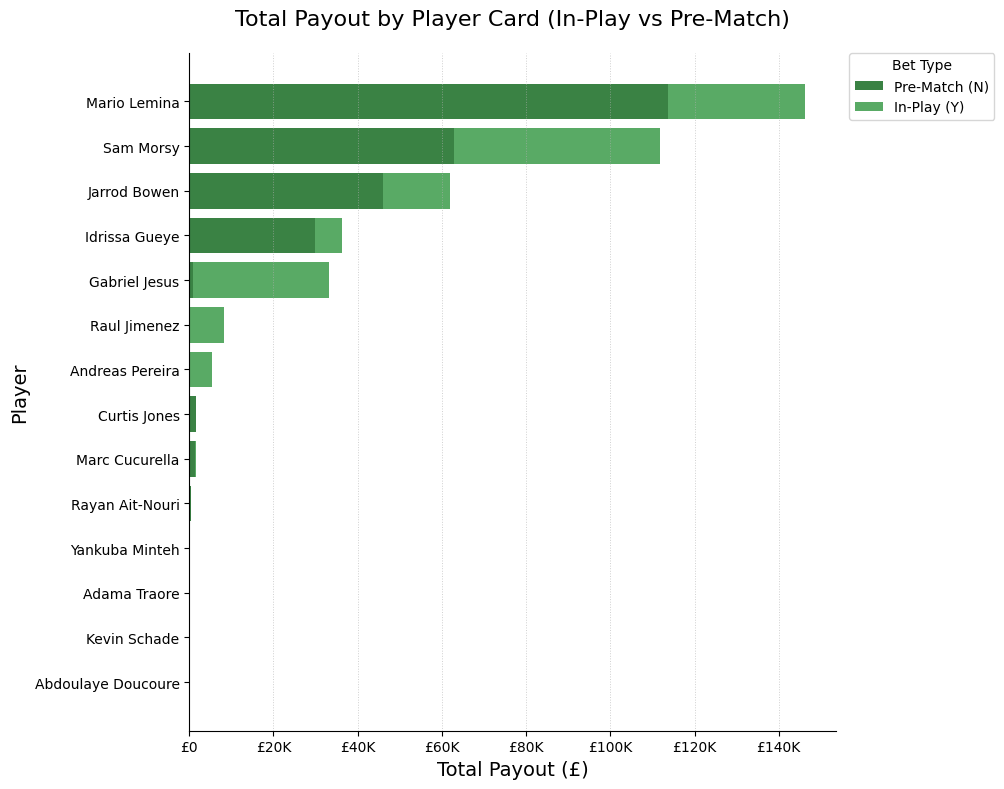

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plot_title = "Total Payout by Player Card (In-Play vs Pre-Match)"

# --- DATA PREPARATION ---
# Group by sportex_selection_name and in_play_yn, sum total_payout
grouped_df = df.groupby(['sportex_selection_name', 'in_play_yn']).agg({
    'total_payout': 'sum'
}).reset_index()

# Pivot to get in-play and pre-match as separate columns
pivot_df = grouped_df.pivot(index='sportex_selection_name', 
                           columns='in_play_yn', 
                           values='total_payout').fillna(0)

# Handle cases where some sports might not have both Y and N values
if 'Y' not in pivot_df.columns:
    pivot_df['Y'] = 0
if 'N' not in pivot_df.columns:
    pivot_df['N'] = 0

# Calculate total payout for sorting
pivot_df['total_payout'] = pivot_df['Y'] + pivot_df['N']

# Sort by total payout (largest to smallest)
pivot_df = pivot_df.sort_values('total_payout', ascending=True)  # ascending=True for horizontal bars

print("Top 10 Sport Selections by Total Payout:")
print(pivot_df[['Y', 'N', 'total_payout']].tail(10))

# --- PLOTTING SETUP ---
sport_selections = pivot_df.index.tolist()
num_selections = len(sport_selections)

# Use viridis colormap - get two distinct colors
viridis_colors = plt.cm.viridis([0.2, 0.8])  # Get colors from viridis palette
in_play_color = '#30953e'     # Darker viridis color for in-play
pre_match_color = '#086315'    # Lighter viridis color for pre-match


# Dynamic figure height based on number of selections
fig, ax = plt.subplots(figsize=(12, max(8, num_selections * 0.4)))

# --- CREATE BARS ---
y_positions = np.arange(num_selections)

# Create horizontal stacked bars
pre_match_values = pivot_df['N'].values
in_play_values = pivot_df['Y'].values

# Plot pre-match (left part of bar)
bars1 = ax.barh(y_positions, pre_match_values, 
                color=pre_match_color, 
                label='Pre-Match (N)',
                alpha=0.8)

# Plot in-play (right part of bar, starting where pre-match ends)
bars2 = ax.barh(y_positions, in_play_values, 
                left=pre_match_values,
                color=in_play_color, 
                label='In-Play (Y)',
                alpha=0.8)

# --- LABELS, TITLE, AND TICKS ---
ax.set_xlabel('Total Payout (£)', fontsize=14)
ax.set_ylabel('Player', fontsize=14)
ax.set_title(plot_title, fontsize=16, pad=20)
ax.set_yticks(y_positions)
ax.set_yticklabels(sport_selections)

# --- FORMATTING ---
# Currency formatter for the x-axis
def currency_formatter_bmt(x, pos):
    if x >= 1_000_000_000:
        return f'£{x*1e-9:1.1f}B'
    if x >= 1_000_000:
        return f'£{x*1e-6:1.1f}M'
    if x >= 1_000:
        return f'£{x*1e-3:1.0f}K'
    return f'£{x:1.0f}'

ax.xaxis.set_major_formatter(mticker.FuncFormatter(currency_formatter_bmt))

# --- LEGEND ---
ax.legend(title='Bet Type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

# --- STYLING AND LAYOUT ---
plt.grid(True, which='major', axis='x', linestyle=':', linewidth=0.7, alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout to make room for labels and legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# --- ADD VALUE LABELS ON BARS (OPTIONAL) ---
# Add percentage labels showing split
for i, (sport_selection, row) in enumerate(pivot_df.iterrows()):
    total = row['total_payout']
    pre_match_pct = (row['N'] / total * 100) if total > 0 else 0
    in_play_pct = (row['Y'] / total * 100) if total > 0 else 0
    
    # Only add labels if the values are significant enough to be readable
    if total > 0:
        # Add total value at the end of each bar
        ax.text(total + total*0.01, i, f'£{total:,.0f}', 
                va='center', ha='left', fontsize=9, alpha=0.8)
        
        # Add percentage splits inside bars (if segments are large enough)
        if pre_match_pct > 5:  # Only show if segment is >5%
            ax.text(row['N']/2, i, f'{pre_match_pct:.0f}%', 
                    va='center', ha='center', fontsize=8, color='white', weight='bold')
        if in_play_pct > 5:  # Only show if segment is >5%
            ax.text(row['N'] + row['Y']/2, i, f'{in_play_pct:.0f}%', 
                    va='center', ha='center', fontsize=8, color='white', weight='bold')

plt.show()

# --- SUMMARY STATISTICS ---
print(f"\nSummary Statistics:")
print(f"Total number of sport selections: {len(sport_selections)}")
print(f"Total payout across all selections: £{pivot_df['total_payout'].sum():,.2f}")
print(f"Total pre-match payout: £{pivot_df['N'].sum():,.2f}")
print(f"Total in-play payout: £{pivot_df['Y'].sum():,.2f}")
print(f"Overall in-play percentage: {(pivot_df['Y'].sum() / pivot_df['total_payout'].sum() * 100):.1f}%")

print(f"\nTop 5 Sport Selections by Total Payout:")
top_5 = pivot_df.tail(5)[['Y', 'N', 'total_payout']].iloc[::-1]  # Reverse to show highest first
for sport, row in top_5.iterrows():
    in_play_pct = (row['Y'] / row['total_payout'] * 100) if row['total_payout'] > 0 else 0
    print(f"  {sport}: £{row['total_payout']:,.0f} ({in_play_pct:.1f}% in-play)")